In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import scipy.io as scp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage.io as skio
from torch.utils.data import Dataset, DataLoader 
from torch.optim.lr_scheduler import StepLR
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # 32x32x32
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 64x32x32
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # 128x32x32
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1) # 128x32x32
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1) # 256x32x32
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1) # 256x32x32
        
        self.fc1 = nn.Linear(256*28*28, 1024) # 1024
        self.fc2 = nn.Linear(1024, 512) # 512
        self.fc3 = nn.Linear(512, 102) # 10
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.6)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.bn1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.bn2(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = self.bn3(x)
        
        # print(f'Shape before flatten: {x.shape}')  
        
        x = self.flatten(x)
        
        # print(f'Shape after flatten: {x.shape}') 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x


In [3]:
# HYPER PARAMETERS
IMG_W = 224
IMG_H = 224
NUM_CLASSES = 102
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.75

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print("Running on: ", device)

# model = CNN(num_channels=3, num_out_ch=NUM_CHANNELS, img_w=IMG_W, img_h=IMG_H, num_classes=NUM_CLASSES).to(device)

# critereon = nn.CrossEntropyLoss()
# optimiser = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model = CNN()
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion.to(device)
model


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=102, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_ru

In [4]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_params(model)
print("Number of parameters: ", params)


Number of parameters:  207226022


In [5]:
transform = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalise the image with mean and standard deviation
])
valid_transforms = transforms.Compose([
        transforms.Resize(224 + 32),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
    transforms.Resize(256), # resize the image to 256x256
    transforms.CenterCrop(224), # crop the image to 224x224 (center)
    transforms.ToTensor(), # convert image from PIL to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalise the image with mean and standard deviation
])

train_set = torchvision.datasets.Flowers102(root="data", download=True, transform=transform)
test_set = torchvision.datasets.Flowers102(root="data", download=True, split="test", transform=test_transform)
val_set = torchvision.datasets.Flowers102(root="data", download=True, split="val", transform=valid_transforms)


In [6]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

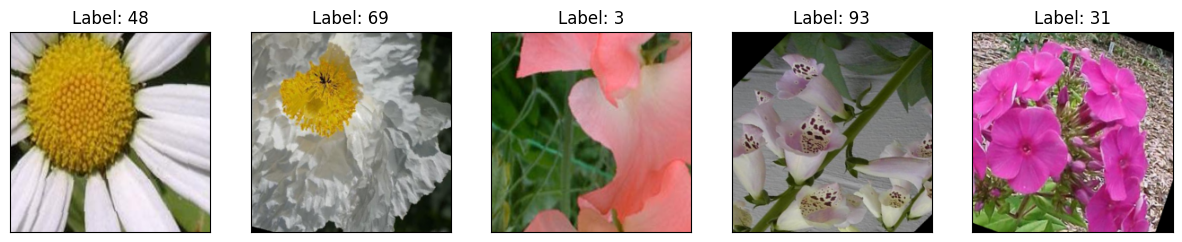

In [7]:
def imshow(img, mean, std):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

num_images = 5

indices = np.random.randint(0, len(train_set), size=num_images)
samples = [train_set[i] for i in indices]

fig = plt.figure(figsize=(num_images * 3, 3))

for idx, (image, label) in enumerate(samples):
    ax = fig.add_subplot(1, num_images, idx + 1, xticks=[], yticks=[])
    imshow(image, mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225]))
    ax.set_title(f'Label: {label}')

plt.show()

In [8]:
training_loss_history = []
testing_accuracy_history = []
testing_loss_history = []

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch}")
    running_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        optimiser.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimiser.step()

        running_loss += loss.item()

        if i % 2000 == 1999:
            training_loss_history.append(running_loss / 2000)
            print(f"Training loss : {running_loss / 2000}")
            running_loss = 0.0


    correct = 0
    total = 0
    total_test_loss = 0.0

    model.eval()
    with torch.no_grad():
        for i, (x_val, y_val) in enumerate(val_loader):
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_val_hat = model(x_val)
            val_loss = criterion(y_val_hat, y_val)
            total_test_loss += val_loss.item()

            _, predicted = torch.max(y_val_hat.data, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()

    testing_loss_history.append(total_test_loss / (len(val_set) / BATCH_SIZE))
    print(f"Test loss : {total_test_loss / (len(val_set) / BATCH_SIZE)}")
    total_test_loss = 0

    accuracy = 100 * correct / total
    testing_accuracy_history.append(accuracy)
    print(f"Test accuracy: {accuracy}")

    model.train()

print('Finished Training')


Epoch 0
Test loss : 4.643519891477099
Test accuracy: 0.9803921568627451
Epoch 1
Test loss : 4.632029245413986
Test accuracy: 0.9803921568627451
Epoch 2
Test loss : 4.538652995988435
Test accuracy: 3.4313725490196076
Epoch 3
Test loss : 4.379702758789063
Test accuracy: 8.529411764705882
Epoch 4
Test loss : 4.254987320245481
Test accuracy: 10.882352941176471
Epoch 5
Test loss : 4.1495491177428
Test accuracy: 10.784313725490197
Epoch 6
Test loss : 4.081672997568168
Test accuracy: 11.666666666666666
Epoch 7
Test loss : 4.000848777621401
Test accuracy: 15.196078431372548
Epoch 8
Test loss : 3.9476491890701593
Test accuracy: 14.803921568627452
Epoch 9
Test loss : 3.847826310700061
Test accuracy: 16.274509803921568
Finished Training


In [9]:
def evaluate_test_data(test_loader, model):
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x)
            _, predictions = y_hat.max(1)
            correct += (predictions == y).sum().item()
            total += predictions.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {correct}/{total}: {accuracy:.2f}%")
    model.train()
    return accuracy

# Evaluate the model on the test data
test_accuracy = evaluate_test_data(test_loader, model)

Test Accuracy: 857/6149: 13.94%
